In [1]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [2]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    xc = np.reshape(xc, (num_data, shape_size))
    yc = np.reshape(yc, (num_data, shape_size))
    
    for j in range(num_data):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    p_u, p_d = 0, 0
    for j in range(1, 200):
        if SP[i][j - 1] >= 0.4 >=SP[i][j]:
            p_d += 1
        if SP[i][j - 1] <= 0.4 <=SP[i][j]:
            p_u += 1
    if p_d == p_u and p_d == 4:
        
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	7
Batch 3 has 	6
Batch 4 has 	17
Batch 5 has 	5
Batch 6 has 	14
Batch 7 has 	14
Batch 8 has 	40
Batch 9 has 	5
Batch 10 has 	14
Batch 11 has 	14
Batch 12 has 	40
Batch 13 has 	13
Batch 14 has 	37
Batch 15 has 	37
Batch 16 has 	106
Batch 17 has 	5
Batch 18 has 	14
Batch 19 has 	14
Batch 20 has 	40
Batch 21 has 	13
Batch 22 has 	37
Batch 23 has 	37
Batch 24 has 	106
Batch 25 has 	13
Batch 26 has 	37
Batch 27 has 	37
Batch 28 has 	106
Batch 29 has 	35
Batch 30 has 	100
Batch 31 has 	100
Batch 32 has 	287
Batch 33 has 	5
Batch 34 has 	14
Batch 35 has 	14
Batch 36 has 	40
Batch 37 has 	13
Batch 38 has 	37
Batch 39 has 	37
Batch 40 has 	106
Batch 41 has 	13
Batch 42 has 	37
Batch 43 has 	37
Batch 44 has 	106
Batch 45 has 	35
Batch 46 has 	100
Batch 47 has 	100
Batch 48 has 	287
Batch 49 has 	13
Batch 50 has 	37
Batch 51 has 	37
Batch 52 has 	106
Batch 53 has 	35
Batch 54 has 	100
Batch 55 has 	100
Batch 56 has 	287
Batch 57 has 	35
Batch 58 has 	100
Batch 59 has 	100
Batch 60 ha

In [3]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

W0731 12:28:43.897278 140225570617152 deprecation_wrapper.py:119] From /home/shengnan/anaconda3/envs/mp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 12:28:43.937517 140225570617152 deprecation_wrapper.py:119] From /home/shengnan/anaconda3/envs/mp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 12:28:43.944574 140225570617152 deprecation_wrapper.py:119] From /home/shengnan/anaconda3/envs/mp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 12:28:44.122054 140225570617152 deprecation_wrapper.py:119] From /home/shengnan/anaconda3/envs/mp/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.comp

Train on 433 samples, validate on 109 samples
Epoch 1/1000
 - 2s - loss: 0.0083 - acc: 0.1247 - val_loss: 0.0048 - val_acc: 0.1560
Epoch 2/1000
 - 0s - loss: 0.0051 - acc: 0.1686 - val_loss: 0.0044 - val_acc: 0.2385
Epoch 3/1000
 - 0s - loss: 0.0047 - acc: 0.1871 - val_loss: 0.0043 - val_acc: 0.2385
Epoch 4/1000
 - 0s - loss: 0.0044 - acc: 0.1917 - val_loss: 0.0040 - val_acc: 0.1468
Epoch 5/1000
 - 0s - loss: 0.0040 - acc: 0.2148 - val_loss: 0.0037 - val_acc: 0.2385
Epoch 6/1000
 - 0s - loss: 0.0034 - acc: 0.3095 - val_loss: 0.0035 - val_acc: 0.3119
Epoch 7/1000
 - 0s - loss: 0.0028 - acc: 0.3118 - val_loss: 0.0030 - val_acc: 0.3761
Epoch 8/1000
 - 0s - loss: 0.0029 - acc: 0.3649 - val_loss: 0.0030 - val_acc: 0.3853
Epoch 9/1000
 - 0s - loss: 0.0023 - acc: 0.4157 - val_loss: 0.0026 - val_acc: 0.3578
Epoch 10/1000
 - 0s - loss: 0.0020 - acc: 0.4065 - val_loss: 0.0024 - val_acc: 0.4128
Epoch 11/1000
 - 0s - loss: 0.0018 - acc: 0.4342 - val_loss: 0.0023 - val_acc: 0.3486
Epoch 12/1000
 - 

Epoch 93/1000
 - 0s - loss: 8.3771e-05 - acc: 0.6605 - val_loss: 0.0021 - val_acc: 0.5413
Epoch 94/1000
 - 0s - loss: 8.3867e-05 - acc: 0.6605 - val_loss: 0.0022 - val_acc: 0.4587
Epoch 95/1000
 - 0s - loss: 9.5313e-05 - acc: 0.6674 - val_loss: 0.0022 - val_acc: 0.4954
Epoch 96/1000
 - 0s - loss: 9.3750e-05 - acc: 0.6651 - val_loss: 0.0022 - val_acc: 0.4587
Epoch 97/1000
 - 0s - loss: 9.2030e-05 - acc: 0.6559 - val_loss: 0.0021 - val_acc: 0.4495
Epoch 98/1000
 - 0s - loss: 8.1081e-05 - acc: 0.6952 - val_loss: 0.0022 - val_acc: 0.4954
Epoch 99/1000
 - 0s - loss: 8.0029e-05 - acc: 0.6467 - val_loss: 0.0022 - val_acc: 0.5046
Epoch 100/1000
 - 0s - loss: 8.2878e-05 - acc: 0.6605 - val_loss: 0.0022 - val_acc: 0.5046
Epoch 101/1000
 - 0s - loss: 1.1731e-04 - acc: 0.6443 - val_loss: 0.0022 - val_acc: 0.5046
Epoch 102/1000
 - 0s - loss: 1.2049e-04 - acc: 0.6559 - val_loss: 0.0022 - val_acc: 0.5229
Epoch 103/1000
 - 0s - loss: 1.1975e-04 - acc: 0.6651 - val_loss: 0.0022 - val_acc: 0.4495
Epoch 

 - 0s - loss: 2.9979e-05 - acc: 0.6790 - val_loss: 0.0021 - val_acc: 0.4954
Epoch 184/1000
 - 0s - loss: 2.4440e-05 - acc: 0.6790 - val_loss: 0.0021 - val_acc: 0.4954
Epoch 185/1000
 - 0s - loss: 2.1553e-05 - acc: 0.6674 - val_loss: 0.0021 - val_acc: 0.4954
Epoch 186/1000
 - 0s - loss: 2.1329e-05 - acc: 0.6905 - val_loss: 0.0021 - val_acc: 0.4679
Epoch 187/1000
 - 0s - loss: 2.4082e-05 - acc: 0.7021 - val_loss: 0.0021 - val_acc: 0.4862
Epoch 188/1000
 - 0s - loss: 2.9821e-05 - acc: 0.6952 - val_loss: 0.0021 - val_acc: 0.4862
Epoch 189/1000
 - 0s - loss: 3.2571e-05 - acc: 0.6859 - val_loss: 0.0021 - val_acc: 0.5505
Epoch 190/1000
 - 0s - loss: 2.7028e-05 - acc: 0.6859 - val_loss: 0.0021 - val_acc: 0.4587
Epoch 191/1000
 - 0s - loss: 2.2440e-05 - acc: 0.7067 - val_loss: 0.0021 - val_acc: 0.4862
Epoch 192/1000
 - 0s - loss: 2.2301e-05 - acc: 0.6721 - val_loss: 0.0021 - val_acc: 0.4679
Epoch 193/1000
 - 0s - loss: 2.4450e-05 - acc: 0.6628 - val_loss: 0.0021 - val_acc: 0.5138
Epoch 194/1000

Epoch 274/1000
 - 0s - loss: 2.8165e-04 - acc: 0.6282 - val_loss: 0.0023 - val_acc: 0.5321
Epoch 275/1000
 - 0s - loss: 2.5169e-04 - acc: 0.6259 - val_loss: 0.0023 - val_acc: 0.5046
Epoch 276/1000
 - 0s - loss: 2.2189e-04 - acc: 0.6351 - val_loss: 0.0022 - val_acc: 0.4954
Epoch 277/1000
 - 0s - loss: 1.9206e-04 - acc: 0.6628 - val_loss: 0.0022 - val_acc: 0.4954
Epoch 278/1000
 - 0s - loss: 1.6442e-04 - acc: 0.5958 - val_loss: 0.0022 - val_acc: 0.5505
Epoch 279/1000
 - 0s - loss: 1.2663e-04 - acc: 0.6605 - val_loss: 0.0021 - val_acc: 0.4771
Epoch 280/1000
 - 0s - loss: 8.1709e-05 - acc: 0.6928 - val_loss: 0.0021 - val_acc: 0.4954
Epoch 281/1000
 - 0s - loss: 5.1641e-05 - acc: 0.6490 - val_loss: 0.0022 - val_acc: 0.4862
Epoch 282/1000
 - 0s - loss: 4.1436e-05 - acc: 0.6813 - val_loss: 0.0021 - val_acc: 0.4679
Epoch 283/1000
 - 0s - loss: 3.1979e-05 - acc: 0.7044 - val_loss: 0.0021 - val_acc: 0.5138
Epoch 284/1000
 - 0s - loss: 2.9146e-05 - acc: 0.7021 - val_loss: 0.0021 - val_acc: 0.4954

 - 0s - loss: 1.7414e-05 - acc: 0.6905 - val_loss: 0.0021 - val_acc: 0.5046
Epoch 365/1000
 - 0s - loss: 1.7047e-05 - acc: 0.6859 - val_loss: 0.0021 - val_acc: 0.5413
Epoch 366/1000
 - 0s - loss: 1.4980e-05 - acc: 0.6536 - val_loss: 0.0021 - val_acc: 0.5138
Epoch 367/1000
 - 0s - loss: 1.2979e-05 - acc: 0.6928 - val_loss: 0.0021 - val_acc: 0.5229
Epoch 368/1000
 - 0s - loss: 1.0173e-05 - acc: 0.6651 - val_loss: 0.0021 - val_acc: 0.5505
Epoch 369/1000
 - 0s - loss: 8.8550e-06 - acc: 0.7275 - val_loss: 0.0021 - val_acc: 0.4954
Epoch 370/1000
 - 0s - loss: 1.0327e-05 - acc: 0.6928 - val_loss: 0.0021 - val_acc: 0.5046
Epoch 371/1000
 - 0s - loss: 9.7840e-06 - acc: 0.6928 - val_loss: 0.0021 - val_acc: 0.4862
Epoch 372/1000
 - 0s - loss: 1.1315e-05 - acc: 0.6513 - val_loss: 0.0021 - val_acc: 0.4495
Epoch 373/1000
 - 0s - loss: 1.1237e-05 - acc: 0.7298 - val_loss: 0.0021 - val_acc: 0.4128
Epoch 374/1000
 - 0s - loss: 9.9577e-06 - acc: 0.7113 - val_loss: 0.0021 - val_acc: 0.4862
Epoch 375/1000

Epoch 455/1000
 - 0s - loss: 5.3243e-05 - acc: 0.6859 - val_loss: 0.0021 - val_acc: 0.5046
Epoch 456/1000
 - 0s - loss: 5.2775e-05 - acc: 0.6952 - val_loss: 0.0021 - val_acc: 0.5413
Epoch 457/1000
 - 0s - loss: 4.4272e-05 - acc: 0.6443 - val_loss: 0.0021 - val_acc: 0.5229
Epoch 458/1000
 - 0s - loss: 3.3000e-05 - acc: 0.6952 - val_loss: 0.0021 - val_acc: 0.4312
Epoch 459/1000
 - 0s - loss: 2.5419e-05 - acc: 0.6905 - val_loss: 0.0021 - val_acc: 0.4954
Epoch 460/1000
 - 0s - loss: 2.3504e-05 - acc: 0.6559 - val_loss: 0.0021 - val_acc: 0.5046
Epoch 461/1000
 - 0s - loss: 1.9369e-05 - acc: 0.6998 - val_loss: 0.0021 - val_acc: 0.5688
Epoch 462/1000
 - 0s - loss: 1.6022e-05 - acc: 0.6882 - val_loss: 0.0021 - val_acc: 0.4679
Epoch 463/1000
 - 0s - loss: 1.2218e-05 - acc: 0.6859 - val_loss: 0.0021 - val_acc: 0.5138
Epoch 464/1000
 - 0s - loss: 8.8459e-06 - acc: 0.7021 - val_loss: 0.0021 - val_acc: 0.5229
Epoch 465/1000
 - 0s - loss: 6.5515e-06 - acc: 0.6975 - val_loss: 0.0020 - val_acc: 0.4954

 - 0s - loss: 9.2180e-06 - acc: 0.6790 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 546/1000
 - 0s - loss: 8.7721e-06 - acc: 0.7136 - val_loss: 0.0020 - val_acc: 0.5229
Epoch 547/1000
 - 0s - loss: 8.1565e-06 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.5688
Epoch 548/1000
 - 0s - loss: 7.2760e-06 - acc: 0.7344 - val_loss: 0.0020 - val_acc: 0.5046
Epoch 549/1000
 - 0s - loss: 7.5066e-06 - acc: 0.6836 - val_loss: 0.0020 - val_acc: 0.5229
Epoch 550/1000
 - 0s - loss: 7.1027e-06 - acc: 0.6882 - val_loss: 0.0020 - val_acc: 0.5229
Epoch 551/1000
 - 0s - loss: 5.9002e-06 - acc: 0.7021 - val_loss: 0.0020 - val_acc: 0.5229
Epoch 552/1000
 - 0s - loss: 4.8500e-06 - acc: 0.6952 - val_loss: 0.0020 - val_acc: 0.5138
Epoch 553/1000
 - 0s - loss: 3.9167e-06 - acc: 0.7182 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 554/1000
 - 0s - loss: 5.0976e-06 - acc: 0.6790 - val_loss: 0.0020 - val_acc: 0.5413
Epoch 555/1000
 - 0s - loss: 6.5094e-06 - acc: 0.7206 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 556/1000

Epoch 636/1000
 - 0s - loss: 4.8447e-05 - acc: 0.7044 - val_loss: 0.0020 - val_acc: 0.4862
Epoch 637/1000
 - 0s - loss: 4.4293e-05 - acc: 0.6582 - val_loss: 0.0021 - val_acc: 0.5780
Epoch 638/1000
 - 0s - loss: 4.9661e-05 - acc: 0.7021 - val_loss: 0.0021 - val_acc: 0.5413
Epoch 639/1000
 - 0s - loss: 6.7120e-05 - acc: 0.6767 - val_loss: 0.0020 - val_acc: 0.5505
Epoch 640/1000
 - 0s - loss: 5.6227e-05 - acc: 0.6767 - val_loss: 0.0021 - val_acc: 0.5046
Epoch 641/1000
 - 0s - loss: 4.1452e-05 - acc: 0.6767 - val_loss: 0.0021 - val_acc: 0.5138
Epoch 642/1000
 - 0s - loss: 3.2594e-05 - acc: 0.6490 - val_loss: 0.0021 - val_acc: 0.5321
Epoch 643/1000
 - 0s - loss: 3.0942e-05 - acc: 0.6790 - val_loss: 0.0020 - val_acc: 0.4954
Epoch 644/1000
 - 0s - loss: 2.6293e-05 - acc: 0.7321 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 645/1000
 - 0s - loss: 3.1978e-05 - acc: 0.6536 - val_loss: 0.0021 - val_acc: 0.4495
Epoch 646/1000
 - 0s - loss: 2.7825e-05 - acc: 0.7090 - val_loss: 0.0021 - val_acc: 0.4862

 - 0s - loss: 1.6288e-06 - acc: 0.6998 - val_loss: 0.0020 - val_acc: 0.5596
Epoch 727/1000
 - 0s - loss: 1.5677e-06 - acc: 0.7367 - val_loss: 0.0020 - val_acc: 0.5229
Epoch 728/1000
 - 0s - loss: 1.3305e-06 - acc: 0.7229 - val_loss: 0.0020 - val_acc: 0.5505
Epoch 729/1000
 - 0s - loss: 1.4193e-06 - acc: 0.7275 - val_loss: 0.0020 - val_acc: 0.5413
Epoch 730/1000
 - 0s - loss: 1.3958e-06 - acc: 0.6998 - val_loss: 0.0020 - val_acc: 0.5505
Epoch 731/1000
 - 0s - loss: 1.4476e-06 - acc: 0.7206 - val_loss: 0.0020 - val_acc: 0.5413
Epoch 732/1000
 - 0s - loss: 1.6345e-06 - acc: 0.7090 - val_loss: 0.0020 - val_acc: 0.5138
Epoch 733/1000
 - 0s - loss: 1.7402e-06 - acc: 0.7413 - val_loss: 0.0020 - val_acc: 0.5780
Epoch 734/1000
 - 0s - loss: 2.1554e-06 - acc: 0.6928 - val_loss: 0.0020 - val_acc: 0.5138
Epoch 735/1000
 - 0s - loss: 2.9010e-06 - acc: 0.7229 - val_loss: 0.0020 - val_acc: 0.5505
Epoch 736/1000
 - 0s - loss: 2.9847e-06 - acc: 0.7136 - val_loss: 0.0020 - val_acc: 0.5046
Epoch 737/1000

Epoch 817/1000
 - 0s - loss: 2.7597e-05 - acc: 0.7090 - val_loss: 0.0020 - val_acc: 0.4404
Epoch 818/1000
 - 0s - loss: 3.2324e-05 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.4862
Epoch 819/1000
 - 0s - loss: 3.2896e-05 - acc: 0.6859 - val_loss: 0.0020 - val_acc: 0.4862
Epoch 820/1000
 - 0s - loss: 2.8002e-05 - acc: 0.6975 - val_loss: 0.0020 - val_acc: 0.4862
Epoch 821/1000
 - 0s - loss: 2.8816e-05 - acc: 0.6882 - val_loss: 0.0020 - val_acc: 0.4954
Epoch 822/1000
 - 0s - loss: 2.9699e-05 - acc: 0.6674 - val_loss: 0.0021 - val_acc: 0.4771
Epoch 823/1000
 - 0s - loss: 2.5974e-05 - acc: 0.6905 - val_loss: 0.0021 - val_acc: 0.4587
Epoch 824/1000
 - 0s - loss: 2.1064e-05 - acc: 0.6998 - val_loss: 0.0020 - val_acc: 0.5138
Epoch 825/1000
 - 0s - loss: 2.7201e-05 - acc: 0.6721 - val_loss: 0.0021 - val_acc: 0.4771
Epoch 826/1000
 - 0s - loss: 2.8577e-05 - acc: 0.7021 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 827/1000
 - 0s - loss: 2.3359e-05 - acc: 0.6674 - val_loss: 0.0020 - val_acc: 0.4679

 - 0s - loss: 1.8213e-06 - acc: 0.6975 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 908/1000
 - 0s - loss: 2.0704e-06 - acc: 0.6790 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 909/1000
 - 0s - loss: 2.0660e-06 - acc: 0.7229 - val_loss: 0.0020 - val_acc: 0.5321
Epoch 910/1000
 - 0s - loss: 2.7479e-06 - acc: 0.7044 - val_loss: 0.0020 - val_acc: 0.4862
Epoch 911/1000
 - 0s - loss: 3.0345e-06 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.5229
Epoch 912/1000
 - 0s - loss: 3.2929e-06 - acc: 0.7136 - val_loss: 0.0020 - val_acc: 0.4954
Epoch 913/1000
 - 0s - loss: 4.8432e-06 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.4862
Epoch 914/1000
 - 0s - loss: 6.1507e-06 - acc: 0.7021 - val_loss: 0.0020 - val_acc: 0.5229
Epoch 915/1000
 - 0s - loss: 1.0816e-05 - acc: 0.6882 - val_loss: 0.0020 - val_acc: 0.4954
Epoch 916/1000
 - 0s - loss: 1.7911e-05 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.4862
Epoch 917/1000
 - 0s - loss: 1.9922e-05 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.4771
Epoch 918/1000

Epoch 998/1000
 - 0s - loss: 1.5519e-05 - acc: 0.6836 - val_loss: 0.0020 - val_acc: 0.4679
Epoch 999/1000
 - 0s - loss: 1.4849e-05 - acc: 0.7298 - val_loss: 0.0020 - val_acc: 0.4771
Epoch 1000/1000
 - 0s - loss: 1.3553e-05 - acc: 0.6882 - val_loss: 0.0020 - val_acc: 0.5321
109/109 [==============================] - 0s 226us/step
[9.793342783804214e-06, 0.6789838253212857]
[0.002004099029347027, 0.5321101034999988]


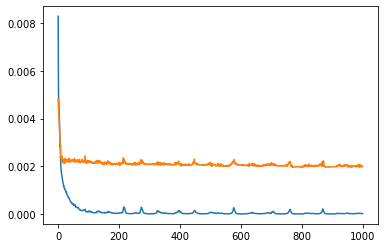

In [4]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True shape: [0.3       0.3       0.4       0.4389726 0.5       0.5      ]
Predicted shape: [[0.3064912  0.3119497  0.4025215  0.4394242  0.49798724 0.49337694]]



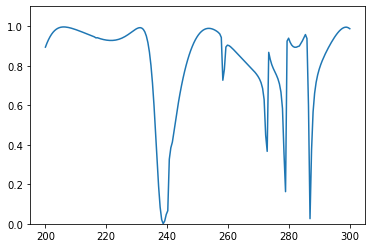

Test 1
True shape: [0.2963065  0.3        0.4        0.39507534 0.4        0.5       ]
Predicted shape: [[0.31375283 0.3026808  0.39733255 0.39221242 0.40130752 0.4692579 ]]



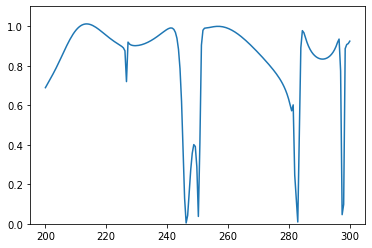

Test 2
True shape: [0.2      0.3      0.3      0.338636 0.4      0.5     ]
Predicted shape: [[0.3195423  0.22433162 0.28953445 0.3793049  0.39726943 0.48038176]]



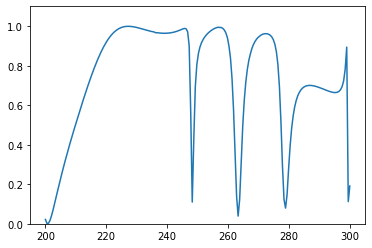

Test 3
True shape: [0.39507534 0.4        0.4        0.3        0.338636   0.4       ]
Predicted shape: [[0.39159143 0.4019267  0.39261207 0.40591186 0.316923   0.31880692]]



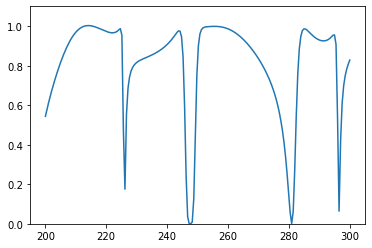

Test 4
True shape: [0.39507534 0.4        0.3631924  0.34026032 0.3276406  0.3236068 ]
Predicted shape: [[0.3573816  0.36050144 0.37466508 0.38704288 0.339137   0.29255268]]



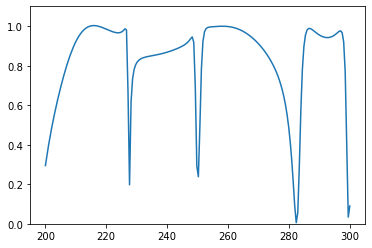

Test 5
True shape: [0.47552826 0.48145578 0.5        0.4        0.4        0.4       ]
Predicted shape: [[0.47068536 0.4462432  0.44061628 0.50368434 0.46005318 0.4621392 ]]



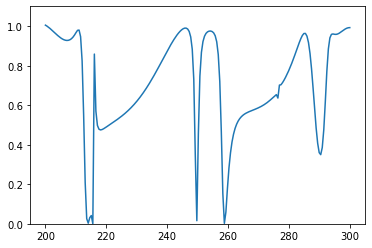

Test 6
True shape: [0.5        0.4        0.3631924  0.34026032 0.3276406  0.3236068 ]
Predicted shape: [[0.47532403 0.37584883 0.3801624  0.37886107 0.39428648 0.34475768]]



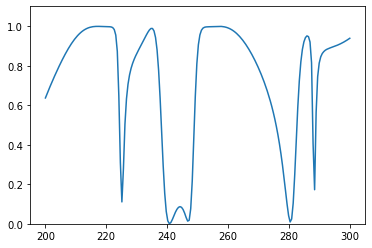

Test 7
True shape: [0.4       0.5       0.4389726 0.4       0.5       0.4      ]
Predicted shape: [[0.4588577  0.49630943 0.42347294 0.40809512 0.43190235 0.48709217]]



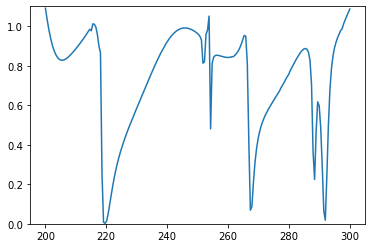

Test 8
True shape: [0.3        0.4        0.5        0.44988746 0.41826582 0.4       ]
Predicted shape: [[0.44252223 0.41243514 0.4623977  0.3965649  0.4170338  0.40668687]]



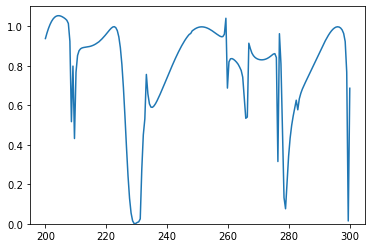

Test 9
True shape: [0.4        0.4        0.39507534 0.4        0.3        0.3       ]
Predicted shape: [[0.39613667 0.3974296  0.40061927 0.39950058 0.30143654 0.29192513]]



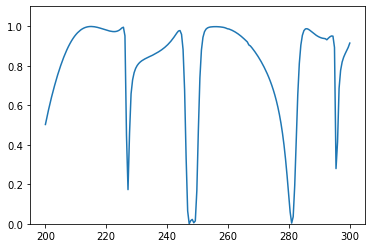

Test 10
True shape: [0.4        0.4        0.3        0.4        0.39507534 0.4       ]
Predicted shape: [[0.40260944 0.39990297 0.3019399  0.40222865 0.40070435 0.39250746]]



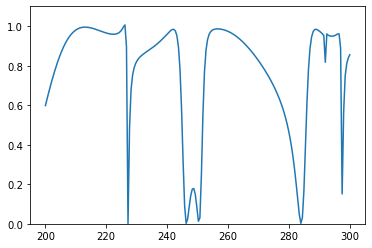

Test 11
True shape: [0.4       0.4389726 0.5       0.4       0.3       0.2963065]
Predicted shape: [[0.399181   0.4360357  0.49840274 0.39632457 0.29984248 0.29833415]]



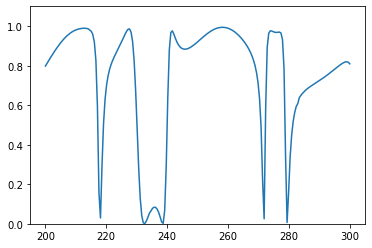

Test 12
True shape: [0.3      0.338636 0.4      0.4      0.3      0.4     ]
Predicted shape: [[0.39551848 0.28155077 0.40026873 0.31739536 0.3657673  0.3019538 ]]



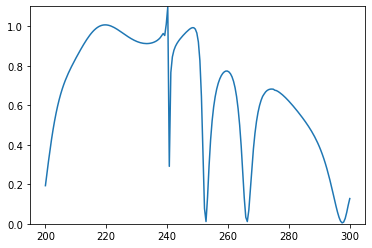

Test 13
True shape: [0.4        0.4        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.40073314 0.40236053 0.30770347 0.3059311  0.21160974 0.19686069]]



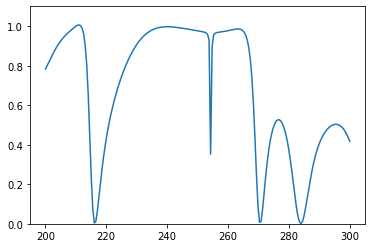

Test 14
True shape: [0.2963065  0.3        0.4        0.5        0.48145578 0.47552826]
Predicted shape: [[0.29690334 0.323461   0.3994407  0.49811682 0.49762642 0.39277408]]



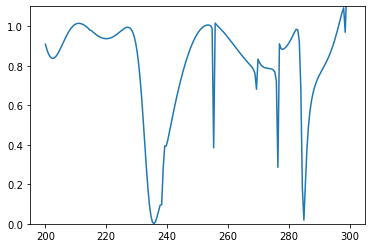

Test 15
True shape: [0.4        0.38516462 0.38042261 0.38516462 0.4        0.5       ]
Predicted shape: [[0.40039    0.39182433 0.40039128 0.3876547  0.40160277 0.42904696]]



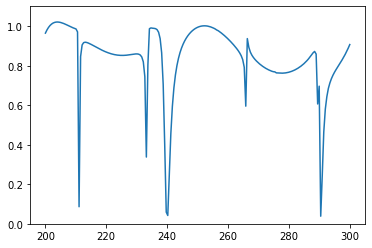

Test 16
True shape: [0.49384417 0.5        0.5        0.4389726  0.4        0.3       ]
Predicted shape: [[0.3724088  0.4390575  0.37945476 0.4336163  0.4642915  0.50040674]]



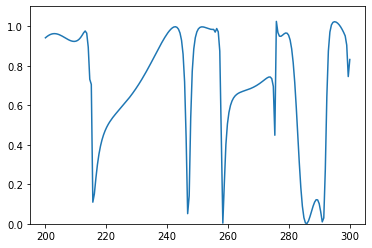

Test 17
True shape: [0.5 0.4 0.4 0.4 0.5 0.4]
Predicted shape: [[0.39288008 0.41066885 0.49765998 0.4136067  0.40488076 0.48022035]]



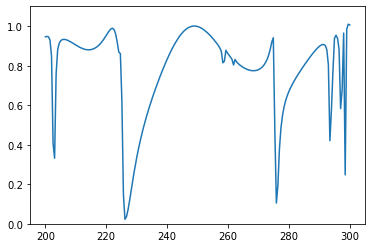

Test 18
True shape: [0.2 0.2 0.3 0.4 0.4 0.4]
Predicted shape: [[0.20234501 0.2023569  0.29831865 0.39680916 0.3996458  0.40299428]]



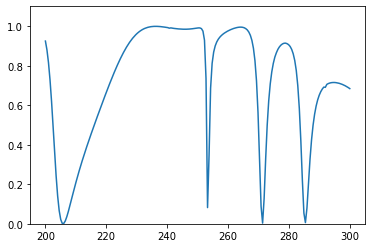

Test 19
True shape: [0.44550326 0.45105652 0.46842985 0.5        0.5        0.49384417]
Predicted shape: [[0.4462522  0.44830027 0.46686673 0.50261796 0.49396217 0.497501  ]]



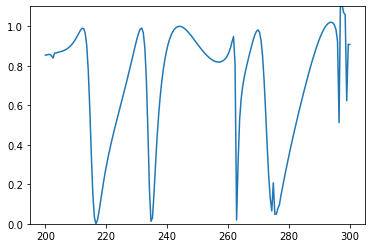

Test 20
True shape: [0.4        0.4        0.4389726  0.5        0.53873909 0.6       ]
Predicted shape: [[0.36254784 0.4051663  0.48538333 0.5022374  0.51946926 0.5626745 ]]



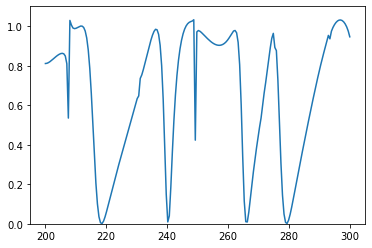

Test 21
True shape: [0.2 0.3 0.4 0.5 0.5 0.5]
Predicted shape: [[0.24099195 0.2964677  0.380154   0.44735476 0.4552001  0.46693984]]



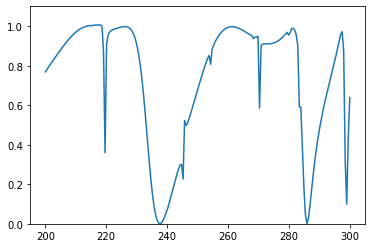

Test 22
True shape: [0.5 0.4 0.4 0.4 0.3 0.4]
Predicted shape: [[0.48618546 0.42688224 0.39545453 0.3824861  0.32039338 0.37880513]]



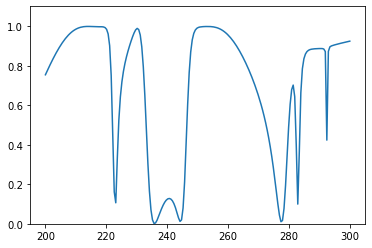

Test 23
True shape: [0.49384417 0.5        0.44988746 0.41826582 0.4        0.5       ]
Predicted shape: [[0.41866428 0.47560742 0.44936344 0.47504905 0.43791738 0.4213587 ]]



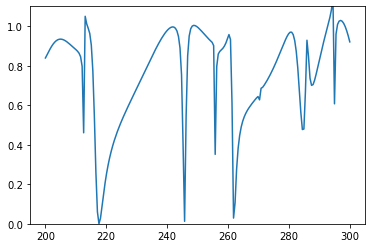

Test 24
True shape: [0.38042261 0.38516462 0.4        0.35084526 0.31945452 0.3       ]
Predicted shape: [[0.37122768 0.37250885 0.37889463 0.39962727 0.327222   0.29924017]]



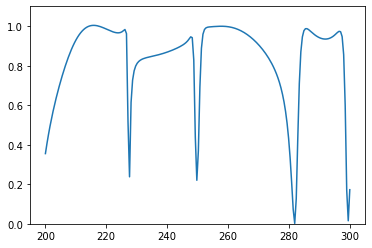

Test 25
True shape: [0.3      0.338636 0.4      0.4      0.5      0.6     ]
Predicted shape: [[0.34061122 0.37213874 0.41541797 0.46315047 0.44684526 0.48337373]]



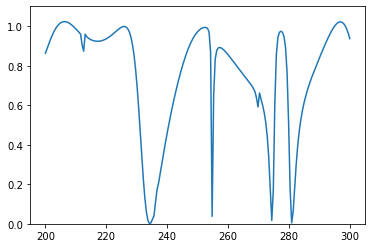

Test 26
True shape: [0.19753767 0.2        0.3        0.4        0.4        0.5       ]
Predicted shape: [[0.28597602 0.25773063 0.28478727 0.29824308 0.38619736 0.4677446 ]]



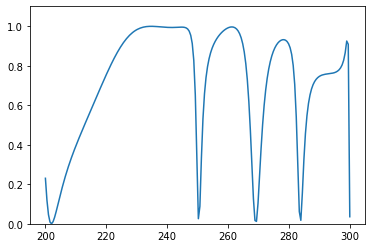

Test 27
True shape: [0.39507534 0.4        0.4        0.41826582 0.44988746 0.5       ]
Predicted shape: [[0.41029847 0.39416912 0.39115655 0.38549596 0.4780229  0.41858813]]



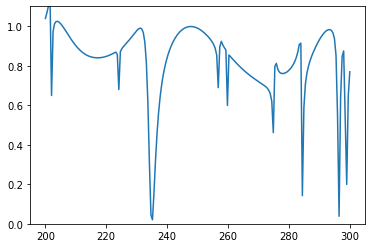

Test 28
True shape: [0.49384417 0.5        0.5        0.4        0.4        0.3       ]
Predicted shape: [[0.4262044  0.43870828 0.4542449  0.37629253 0.36224827 0.31602812]]



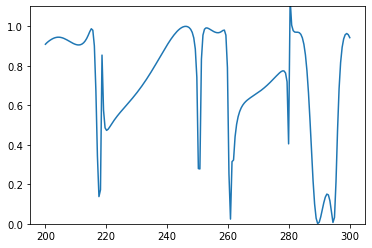

Test 29
True shape: [0.4       0.5       0.5       0.4       0.3       0.2963065]
Predicted shape: [[0.39787194 0.49549198 0.49950212 0.40041372 0.30116373 0.2971931 ]]



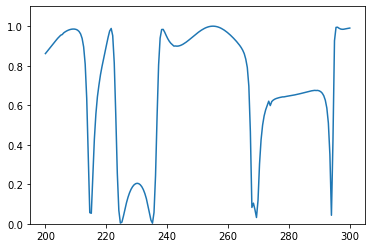

Test 30
True shape: [0.39507534 0.4        0.39015067 0.39015067 0.4        0.5       ]
Predicted shape: [[0.37709698 0.39411268 0.39070854 0.4031392  0.4052801  0.49522674]]



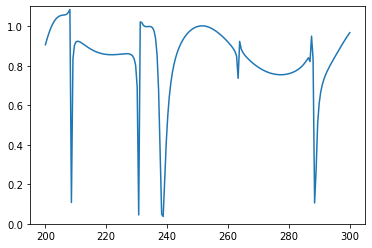

Test 31
True shape: [0.35640261 0.36084521 0.37474388 0.4        0.5        0.5       ]
Predicted shape: [[0.33120543 0.33696693 0.39130548 0.46204045 0.39695653 0.44699565]]



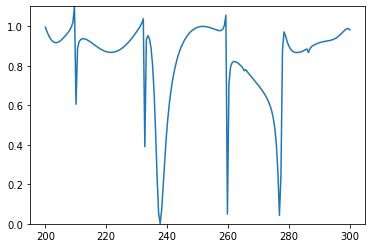

Test 32
True shape: [0.39507534 0.4        0.5        0.4389726  0.4        0.4       ]
Predicted shape: [[0.403552   0.40079132 0.4995968  0.44160798 0.4085681  0.38967586]]



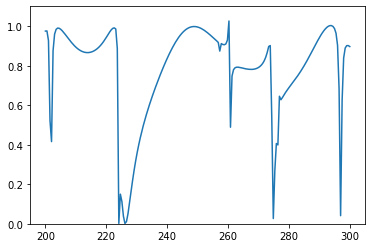

Test 33
True shape: [0.3      0.4      0.4      0.338636 0.3      0.4     ]
Predicted shape: [[0.34086895 0.40013635 0.39860228 0.3896258  0.29117772 0.25066987]]



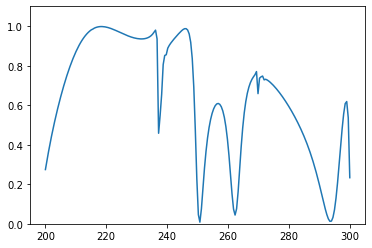

Test 34
True shape: [0.3 0.4 0.5 0.4 0.3 0.2]
Predicted shape: [[0.47068647 0.41694567 0.32437947 0.39549    0.28295666 0.25527087]]



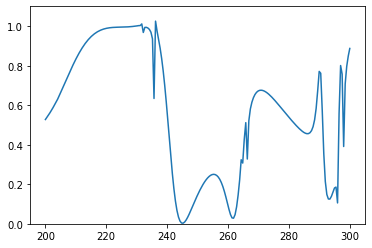

Test 35
True shape: [0.4 0.5 0.5 0.4 0.3 0.2]
Predicted shape: [[0.43121773 0.4701797  0.4180092  0.37792665 0.3095072  0.31726694]]



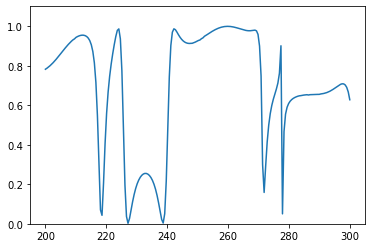

Test 36
True shape: [0.4 0.4 0.4 0.4 0.5 0.4]
Predicted shape: [[0.39077824 0.40775472 0.41506088 0.42198524 0.48351768 0.40279686]]



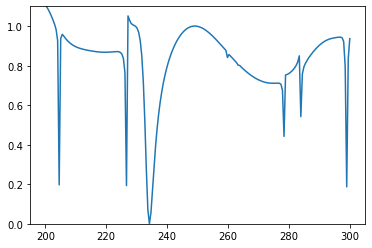

Test 37
True shape: [0.3        0.4        0.39015067 0.39015067 0.4        0.39507534]
Predicted shape: [[0.30148098 0.39559668 0.3948688  0.40658957 0.4053661  0.3772901 ]]



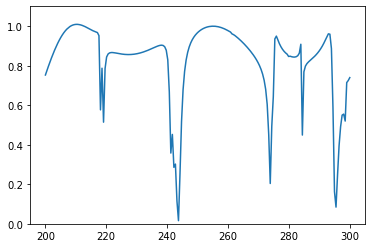

Test 38
True shape: [0.39507534 0.4        0.41826582 0.44988746 0.5        0.5       ]
Predicted shape: [[0.3992284  0.40602946 0.4187085  0.45659184 0.49214202 0.4750483 ]]



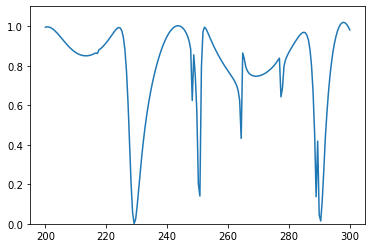

Test 39
True shape: [0.4        0.3        0.4        0.5        0.5        0.49384417]
Predicted shape: [[0.34418774 0.36997652 0.40388113 0.47007173 0.446143   0.46185532]]



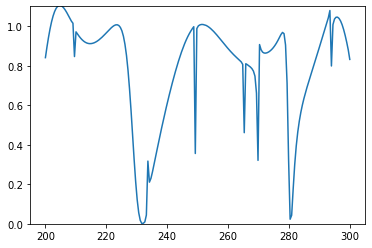

Test 40
True shape: [0.5       0.4       0.3       0.4       0.4389726 0.5      ]
Predicted shape: [[0.428411   0.37750858 0.36224318 0.412638   0.42358732 0.5204802 ]]



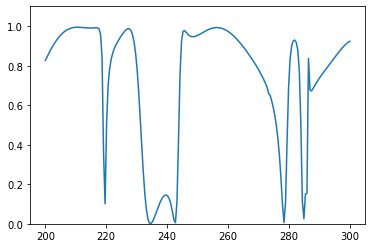

Test 41
True shape: [0.5 0.5 0.5 0.4 0.4 0.3]
Predicted shape: [[0.4296046  0.43653834 0.4465442  0.34847116 0.38000682 0.3516711 ]]



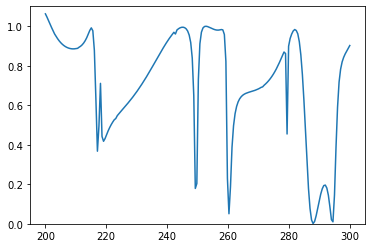

Test 42
True shape: [0.3        0.3        0.4        0.41826582 0.44988746 0.5       ]
Predicted shape: [[0.32922632 0.35755098 0.38701105 0.4192107  0.44096306 0.36170435]]



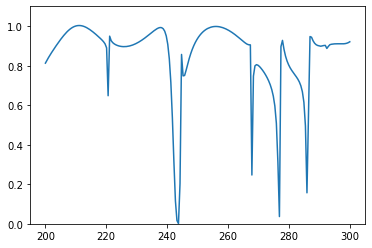

Test 43
True shape: [0.49384417 0.5        0.4        0.3        0.338636   0.4       ]
Predicted shape: [[0.44517088 0.4940976  0.41638502 0.34603846 0.35796708 0.3009339 ]]



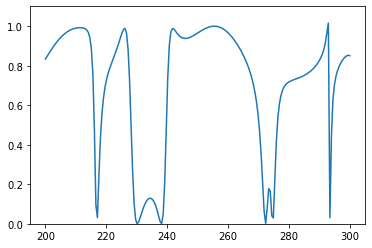

Test 44
True shape: [0.39507534 0.4        0.39507534 0.4        0.3        0.2963065 ]
Predicted shape: [[0.39552364 0.39757842 0.3995034  0.40043923 0.3022796  0.29669398]]



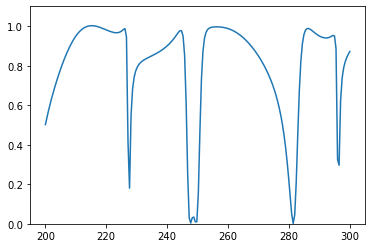

Test 45
True shape: [0.39507534 0.4        0.4        0.4        0.338636   0.3       ]
Predicted shape: [[0.3410204  0.37654552 0.39379898 0.40537688 0.42388663 0.37063837]]



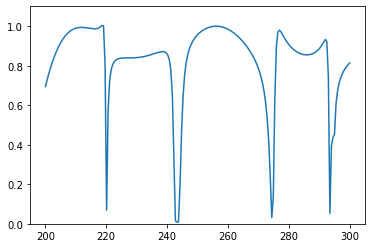

Test 46
True shape: [0.49384417 0.5        0.4        0.3        0.2        0.19753767]
Predicted shape: [[0.49263638 0.49917436 0.40530062 0.2980747  0.20527188 0.20146257]]



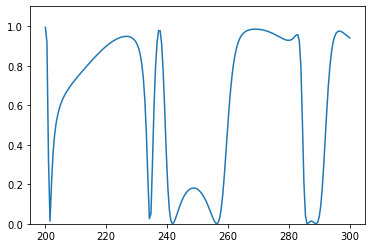

Test 47
True shape: [0.4      0.4      0.5      0.4      0.338636 0.3     ]
Predicted shape: [[0.43610126 0.40521836 0.40182272 0.4186907  0.3842788  0.38006136]]



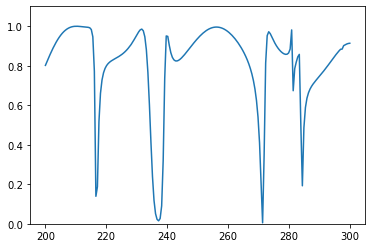

Test 48
True shape: [0.3        0.31945452 0.35084526 0.4        0.4389726  0.5       ]
Predicted shape: [[0.3906151  0.34007734 0.37963578 0.38538292 0.37662175 0.4737637 ]]



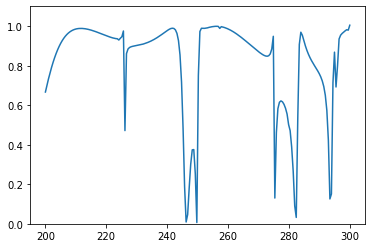

Test 49
True shape: [0.39507534 0.4        0.3        0.4        0.4        0.4       ]
Predicted shape: [[0.3959809  0.399238   0.30368567 0.4018388  0.40199414 0.3918283 ]]



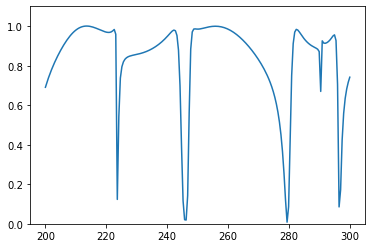

Test 50
True shape: [0.4        0.4        0.3        0.338636   0.4        0.39507534]
Predicted shape: [[0.40183342 0.39619017 0.31698933 0.32582775 0.39717922 0.4004    ]]



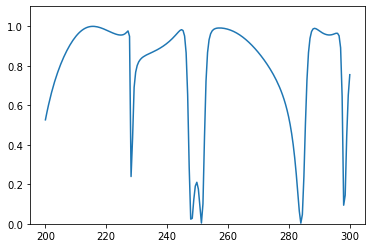

Test 51
True shape: [0.2 0.2 0.3 0.3 0.4 0.4]
Predicted shape: [[0.1987549  0.19957265 0.2962144  0.3013816  0.40135112 0.39482024]]



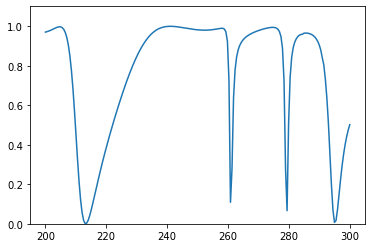

Test 52
True shape: [0.2 0.2 0.3 0.4 0.4 0.5]
Predicted shape: [[0.298078   0.26028383 0.28143808 0.2853836  0.38435525 0.45702899]]



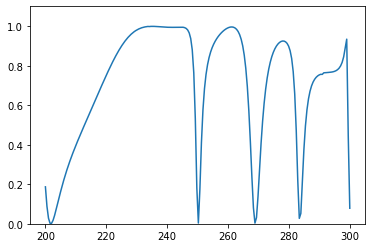

Test 53
True shape: [0.2963065  0.3        0.4        0.4389726  0.5        0.49384417]
Predicted shape: [[0.29849777 0.30022186 0.39787844 0.4352185  0.50215834 0.48879352]]



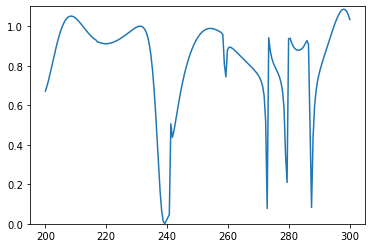

Test 54
True shape: [0.4        0.39507534 0.4        0.3        0.4        0.39507534]
Predicted shape: [[0.38910156 0.3954218  0.4020704  0.30999702 0.4022752  0.41142252]]



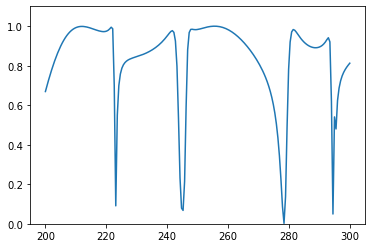

Test 55
True shape: [0.3       0.3       0.4       0.4       0.4389726 0.5      ]
Predicted shape: [[0.37130207 0.32940337 0.3591858  0.40455365 0.46072206 0.4374202 ]]



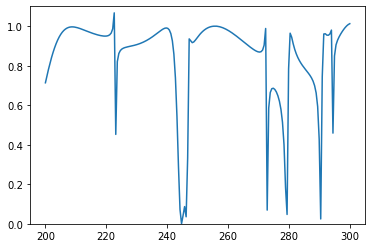

Test 56
True shape: [0.49384417 0.5        0.4389726  0.4        0.3        0.2963065 ]
Predicted shape: [[0.43690243 0.44247338 0.40832517 0.38630667 0.3525839  0.32722923]]



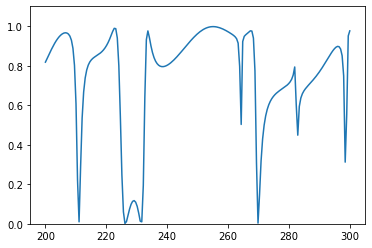

Test 57
True shape: [0.39507534 0.4        0.3        0.4        0.4389726  0.5       ]
Predicted shape: [[0.35726357 0.35805458 0.38306433 0.40865    0.4380778  0.46364528]]



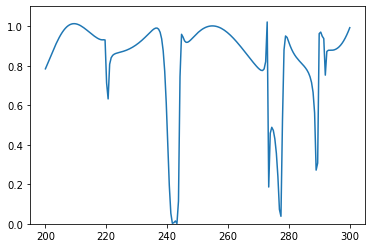

Test 58
True shape: [0.4      0.4      0.338636 0.3      0.338636 0.4     ]
Predicted shape: [[0.40269855 0.4182604  0.34277022 0.36378306 0.3491275  0.31372577]]



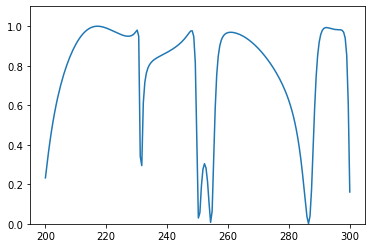

Test 59
True shape: [0.5        0.5        0.4        0.39507534 0.4        0.39507534]
Predicted shape: [[0.49062598 0.49755645 0.40288496 0.3949336  0.40159515 0.39504707]]



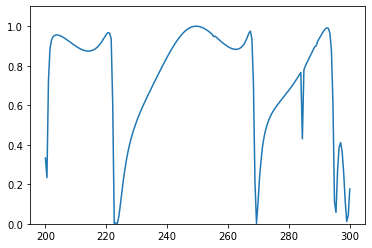

Test 60
True shape: [0.5       0.5       0.4       0.4       0.3       0.2963065]
Predicted shape: [[0.4181495  0.48592407 0.41815633 0.37544852 0.33389094 0.34696135]]



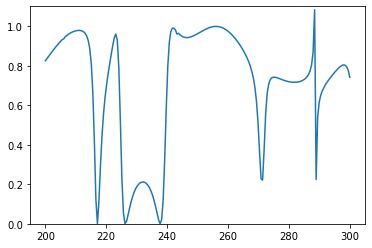

Test 61
True shape: [0.5        0.4        0.41826582 0.44988746 0.5        0.49384417]
Predicted shape: [[0.43147475 0.45188433 0.42880726 0.4732944  0.50706565 0.4773713 ]]



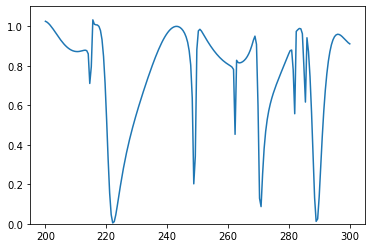

Test 62
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.4        0.5       ]
Predicted shape: [[0.29465497 0.24737754 0.30812585 0.3747873  0.40414163 0.47272325]]



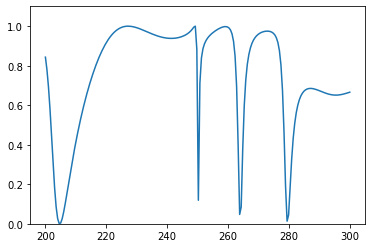

Test 63
True shape: [0.2       0.2370452 0.3       0.338636  0.4       0.5      ]
Predicted shape: [[0.22209236 0.30047297 0.29884684 0.30186903 0.39913374 0.5027628 ]]



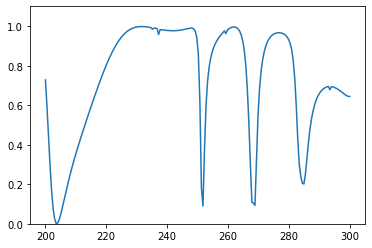

Test 64
True shape: [0.19753767 0.2        0.3        0.3        0.4        0.5       ]
Predicted shape: [[0.21303248 0.20156741 0.30113724 0.30868515 0.40028992 0.5045994 ]]



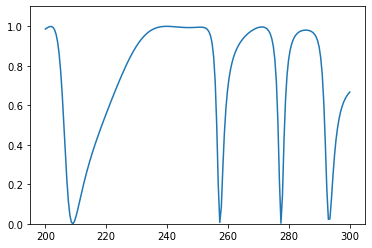

Test 65
True shape: [0.2963065 0.3       0.4       0.5       0.4       0.5      ]
Predicted shape: [[0.3230395  0.31269753 0.41424015 0.46090865 0.41691217 0.3795189 ]]



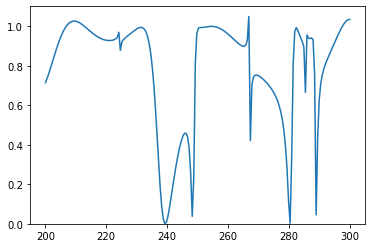

Test 66
True shape: [0.4 0.4 0.3 0.4 0.4 0.3]
Predicted shape: [[0.36329442 0.38694018 0.35120726 0.3309601  0.42986125 0.39434883]]



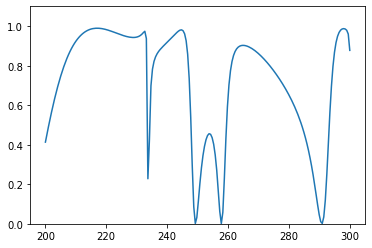

Test 67
True shape: [0.3 0.4 0.4 0.5 0.5 0.4]
Predicted shape: [[0.3894332  0.3907576  0.3956964  0.46101898 0.45079306 0.4676618 ]]



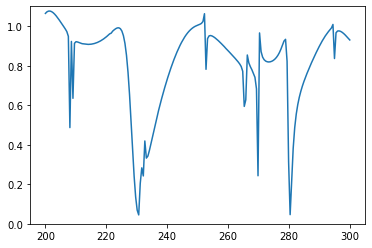

Test 68
True shape: [0.4        0.39507534 0.4        0.4        0.5        0.5       ]
Predicted shape: [[0.399925   0.3995602  0.39610228 0.4015723  0.5011037  0.49452326]]



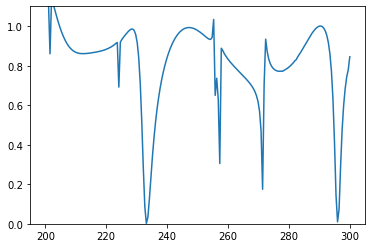

Test 69
True shape: [0.4       0.4389726 0.5       0.4389726 0.4       0.5      ]
Predicted shape: [[0.4056221  0.4060474  0.49050835 0.45114255 0.47501934 0.38130978]]



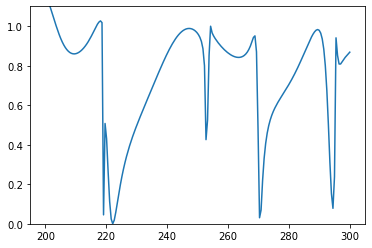

Test 70
True shape: [0.4        0.4        0.4        0.5        0.49384417 0.5       ]
Predicted shape: [[0.37849036 0.37699547 0.40204957 0.49249363 0.49202794 0.42817977]]



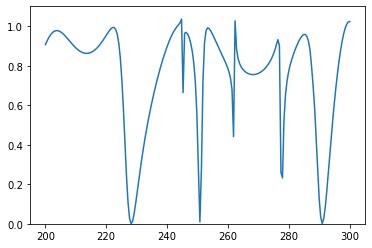

Test 71
True shape: [0.5        0.4        0.4389726  0.5        0.5        0.49384417]
Predicted shape: [[0.47605062 0.4598701  0.40261886 0.4633067  0.47406915 0.47654876]]



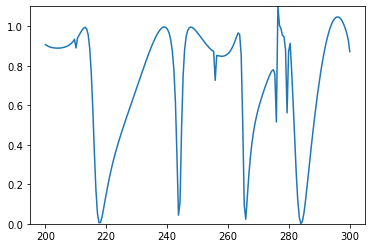

Test 72
True shape: [0.39507534 0.4        0.4389726  0.5        0.5        0.49384417]
Predicted shape: [[0.38770884 0.39333665 0.43830904 0.48399138 0.49443674 0.4985008 ]]



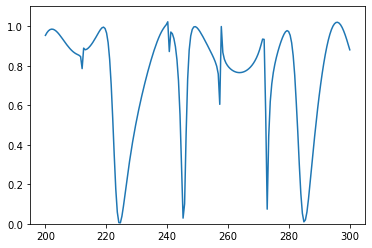

Test 73
True shape: [0.2        0.2        0.3        0.338636   0.4        0.39507534]
Predicted shape: [[0.20352998 0.20185369 0.2977739  0.34162325 0.40171024 0.39725244]]



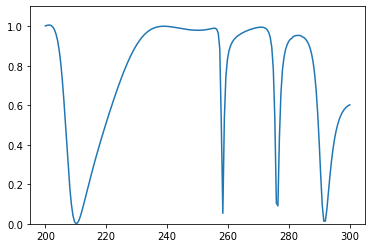

Test 74
True shape: [0.3      0.338636 0.4      0.4      0.5      0.5     ]
Predicted shape: [[0.35147893 0.31024164 0.40891916 0.4066091  0.4935538  0.4864299 ]]



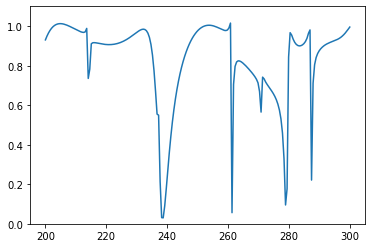

Test 75
True shape: [0.4       0.5       0.4389726 0.4       0.3       0.2963065]
Predicted shape: [[0.39793706 0.49550444 0.44049633 0.39585763 0.29536712 0.2999733 ]]



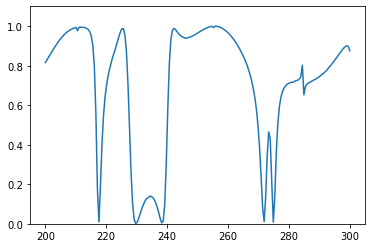

Test 76
True shape: [0.4        0.5        0.4        0.5        0.4        0.39507534]
Predicted shape: [[0.36029482 0.4345325  0.41719225 0.39890718 0.3854222  0.42716315]]



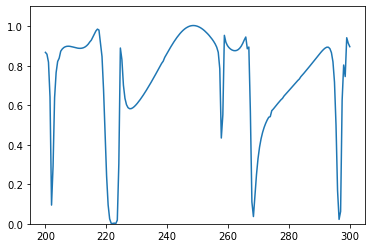

Test 77
True shape: [0.4        0.39507534 0.4        0.5        0.5        0.49384417]
Predicted shape: [[0.39201748 0.39863843 0.4058966  0.492577   0.50236595 0.49569038]]



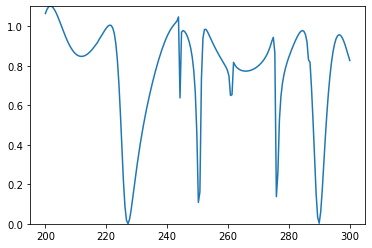

Test 78
True shape: [0.39507534 0.4        0.3        0.4        0.5        0.49384417]
Predicted shape: [[0.38694522 0.3261757  0.40598533 0.41040298 0.47382    0.45730147]]



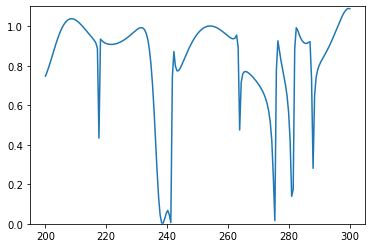

Test 79
True shape: [0.39507534 0.4        0.3        0.3        0.2        0.3       ]
Predicted shape: [[0.40256363 0.39342183 0.36229086 0.3018311  0.21940719 0.19943978]]



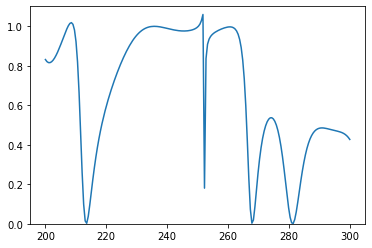

Test 80
True shape: [0.39507534 0.4        0.5        0.5        0.4        0.4       ]
Predicted shape: [[0.39670703 0.40122786 0.4952193  0.5006789  0.40099713 0.39051467]]



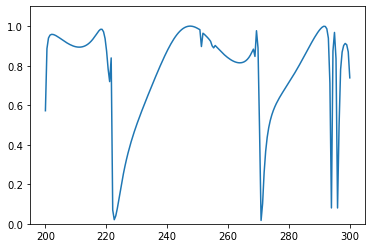

Test 81
True shape: [0.39507534 0.4        0.4389726  0.5        0.4        0.3       ]
Predicted shape: [[0.41416264 0.38623005 0.39988458 0.4608283  0.4079194  0.33203045]]



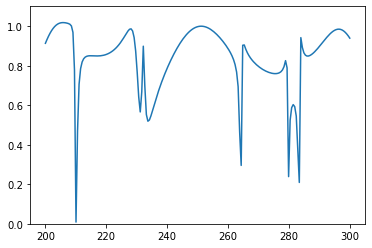

Test 82
True shape: [0.4        0.39507534 0.4        0.338636   0.3        0.2       ]
Predicted shape: [[0.3862613  0.391392   0.38858187 0.33155593 0.31223652 0.22898155]]



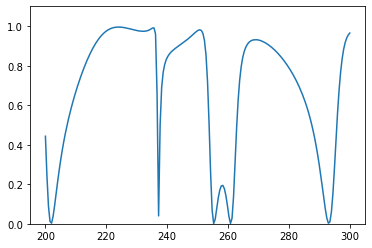

Test 83
True shape: [0.4        0.3        0.4        0.39507534 0.4        0.5       ]
Predicted shape: [[0.3678985  0.30904007 0.36360466 0.39538258 0.44046175 0.45906386]]



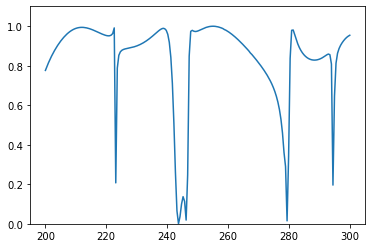

Test 84
True shape: [0.49384417 0.5        0.4        0.338636   0.3        0.2963065 ]
Predicted shape: [[0.48948547 0.5009465  0.40160236 0.3503121  0.29773945 0.29386783]]



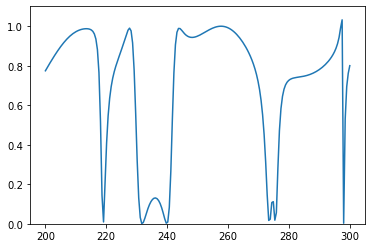

Test 85
True shape: [0.4      0.4      0.4      0.3      0.338636 0.4     ]
Predicted shape: [[0.40704724 0.39268112 0.3486848  0.36654502 0.34079564 0.33557585]]



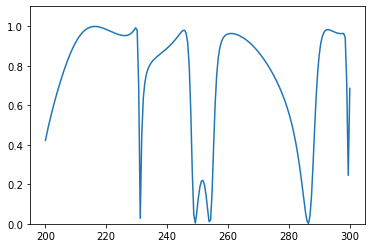

Test 86
True shape: [0.5      0.4      0.3      0.3      0.338636 0.4     ]
Predicted shape: [[0.4573218  0.41072366 0.3158151  0.3976546  0.28782848 0.25356126]]



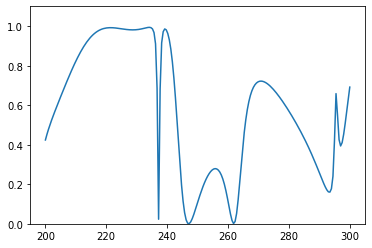

Test 87
True shape: [0.4        0.5        0.4        0.3        0.4        0.39507534]
Predicted shape: [[0.45831603 0.469578   0.39656624 0.338475   0.38063145 0.3839317 ]]



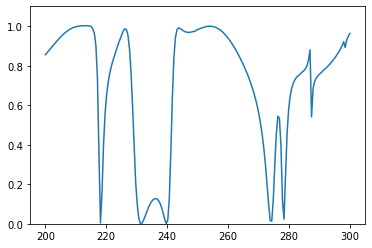

Test 88
True shape: [0.4        0.4        0.338636   0.3        0.4        0.39507534]
Predicted shape: [[0.39981642 0.39849472 0.33566552 0.29829434 0.4009149  0.39923868]]



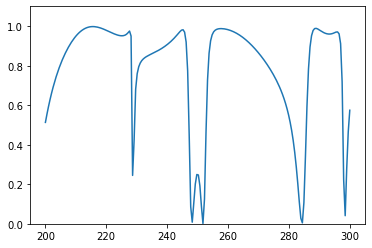

Test 89
True shape: [0.2       0.3       0.2963065 0.3       0.4       0.3      ]
Predicted shape: [[0.21527001 0.24190399 0.29971528 0.3038223  0.38445422 0.37147793]]



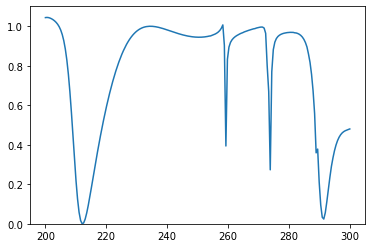

Test 90
True shape: [0.49384417 0.5        0.5        0.4389726  0.4        0.39507534]
Predicted shape: [[0.41056785 0.41936028 0.44265574 0.456466   0.46620762 0.4432552 ]]



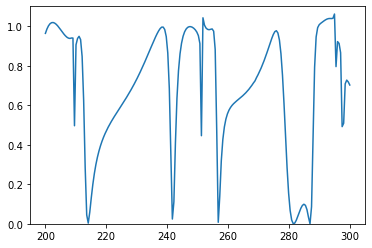

Test 91
True shape: [0.39507534 0.4        0.39507534 0.4        0.4        0.5       ]
Predicted shape: [[0.38091865 0.38712722 0.38359773 0.40397024 0.42184937 0.48987284]]



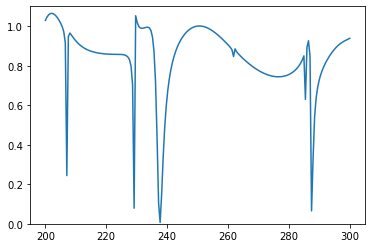

Test 92
True shape: [0.3       0.2963065 0.3       0.4       0.5       0.6      ]
Predicted shape: [[0.29914746 0.2977816  0.30299455 0.39859694 0.5045762  0.5966523 ]]



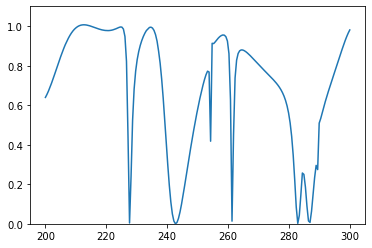

Test 93
True shape: [0.5        0.49384417 0.5        0.4        0.4        0.4       ]
Predicted shape: [[0.3985796  0.3890306  0.4153471  0.44404873 0.4389622  0.4238378 ]]



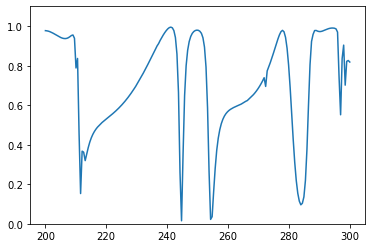

Test 94
True shape: [0.2 0.3 0.3 0.4 0.3 0.4]
Predicted shape: [[0.2004379  0.21983    0.2853188  0.38317573 0.38999557 0.30028686]]



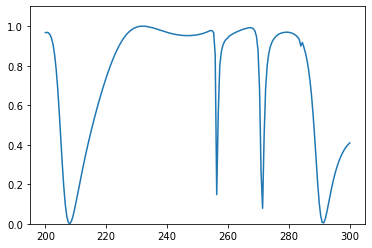

Test 95
True shape: [0.5        0.4        0.39507534 0.4        0.3        0.3       ]
Predicted shape: [[0.48995653 0.38987243 0.3726145  0.41528243 0.30509076 0.3240042 ]]



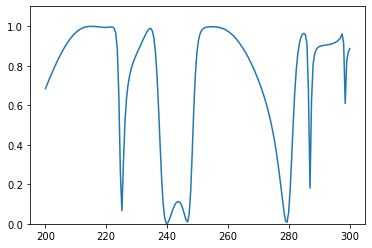

Test 96
True shape: [0.5      0.4      0.338636 0.3      0.338636 0.4     ]
Predicted shape: [[0.38680246 0.35389    0.2981138  0.38326967 0.42862684 0.4993059 ]]



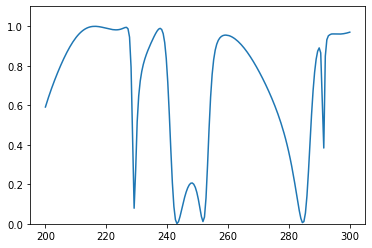

Test 97
True shape: [0.38042261 0.38516462 0.4        0.4        0.338636   0.3       ]
Predicted shape: [[0.31924927 0.36402053 0.3913101  0.41792017 0.36833772 0.41381347]]



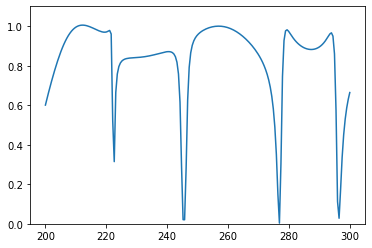

Test 98
True shape: [0.4        0.4        0.4389726  0.5        0.48145578 0.47552826]
Predicted shape: [[0.37184232 0.4542855  0.40204072 0.45872235 0.44794607 0.46462741]]



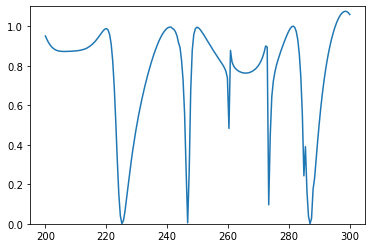

Test 99
True shape: [0.5        0.49384417 0.5        0.49384417 0.5        0.5       ]
Predicted shape: [[0.48360613 0.36843866 0.42615923 0.41662368 0.4080965  0.5074964 ]]



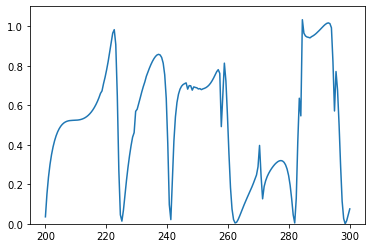

Test 100
True shape: [0.4       0.3       0.4       0.4       0.3       0.2963065]
Predicted shape: [[0.39652863 0.29277876 0.39888036 0.3991472  0.30589378 0.30754763]]



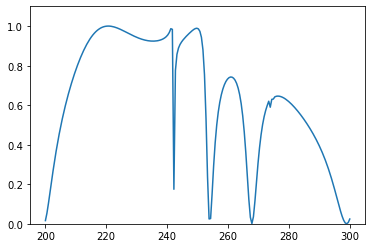

Test 101
True shape: [0.3       0.4       0.4       0.5       0.4389726 0.4      ]
Predicted shape: [[0.3722814  0.3964044  0.42958984 0.4191419  0.46969798 0.40352172]]



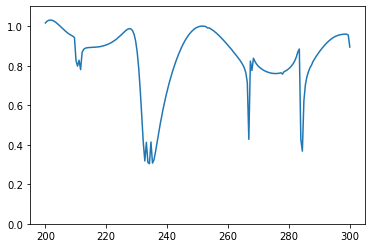

Test 102
True shape: [0.2963065 0.3       0.4       0.5       0.4       0.3      ]
Predicted shape: [[0.43435287 0.34806687 0.32672924 0.38795    0.38002554 0.48214072]]



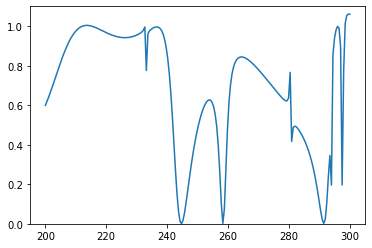

Test 103
True shape: [0.4        0.4        0.39507534 0.4        0.4        0.5       ]
Predicted shape: [[0.3710121  0.36028215 0.38562626 0.40185454 0.43889266 0.4902386 ]]



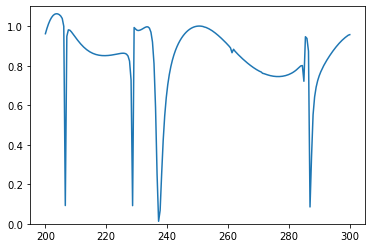

Test 104
True shape: [0.5      0.4      0.3      0.4      0.338636 0.3     ]
Predicted shape: [[0.45254603 0.41638863 0.36728305 0.39250422 0.30503744 0.31567162]]



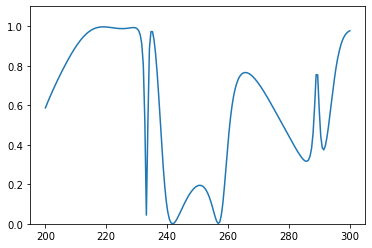

Test 105
True shape: [0.39507534 0.4        0.5        0.48768834 0.48768834 0.5       ]
Predicted shape: [[0.4113512  0.41021168 0.46494466 0.48399    0.47527847 0.4593939 ]]



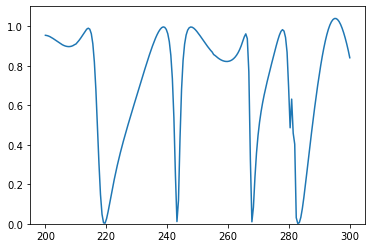

Test 106
True shape: [0.4        0.38516462 0.38042261 0.38516462 0.4        0.39507534]
Predicted shape: [[0.3823777  0.38966244 0.39710897 0.38951245 0.38735557 0.40147313]]



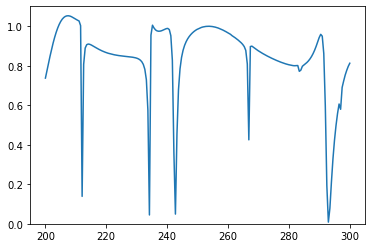

Test 107
True shape: [0.2963065 0.3       0.4       0.5       0.5       0.4      ]
Predicted shape: [[0.29725286 0.3172933  0.41071546 0.5092744  0.48535782 0.42562917]]



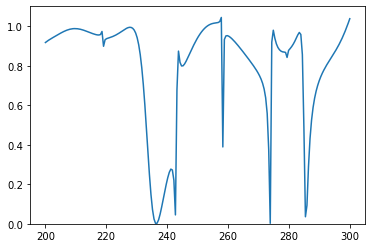

Test 108
True shape: [0.3       0.4       0.5       0.5       0.4389726 0.4      ]
Predicted shape: [[0.44813335 0.37719968 0.4219505  0.4537714  0.46976176 0.48828906]]



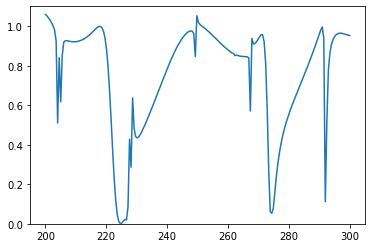

In [6]:
predicted = []
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))